In [1]:
# Data Manipulation Libraries
import numpy as np
import pandas as pd
from datetime import datetime

# Import modularization 
import os
import sys 
sys.path.append(os.path.abspath('../scripts'))
import data_preprocessing as dp
import descriptive_stats as ss
import utils as ut 
import modeling as m

# Plotting Libraries
from matplotlib import pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import joblib

In [5]:
train_file = ('../rossmann-store-sales/train.csv')
test_file = ('../rossmann-store-sales/test.csv')
store_file = ('../rossmann-store-sales/store.csv')

In [6]:
df_train, df_test, df_store = dp.load_data(train_file, test_file, store_file)

##### creating the whole dataset by merging  train and test dataset with data store

In [7]:
train_full = df_train.merge(df_store, how='left', on="Store")
train_full

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,Year,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,7,2015,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,7,2015,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,7,2015,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,7,2015,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,7,2015,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844333,682,2,2013-01-01,3375,566,1,0,a,1,1,2013,b,a,150.0,9.0,2006.0,0,0.0,0.0,0
844334,733,2,2013-01-01,10765,2377,1,0,a,1,1,2013,b,b,860.0,10.0,1999.0,0,0.0,0.0,0
844335,769,2,2013-01-01,5035,1248,1,0,a,1,1,2013,b,b,840.0,0.0,0.0,1,48.0,2012.0,"Jan,Apr,Jul,Oct"
844336,948,2,2013-01-01,4491,1039,1,0,a,1,1,2013,b,b,1430.0,0.0,0.0,0,0.0,0.0,0


In [8]:
test_full = df_test.merge(df_store, on="Store", how="left")
test_full

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,0.0,0.0,0
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,0.0,0.0,0
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
41084,41085,1112,6,2015-08-01,1.0,0,0,0,c,c,1880.0,4.0,2006.0,0,0.0,0.0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0,a,c,9260.0,0.0,0.0,0,0.0,0.0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0,a,c,870.0,0.0,0.0,0,0.0,0.0,0


In [9]:
train_full.nunique()

Store                         1115
DayOfWeek                        7
Date                           942
Sales                        21733
Customers                     4083
Open                             1
Promo                            2
StateHoliday                     4
SchoolHoliday                    2
Month                           12
Year                             3
StoreType                        4
Assortment                       3
CompetitionDistance            655
CompetitionOpenSinceMonth       13
CompetitionOpenSinceYear        24
Promo2                           2
Promo2SinceWeek                 25
Promo2SinceYear                  8
PromoInterval                    4
dtype: int64

#### state holiday should be 4 unique values but it's 5

In [10]:
train_full.StateHoliday.value_counts()

StateHoliday
0    843428
a       694
b       145
c        71
Name: count, dtype: int64

In [11]:
# Replace sting '0' with integer 0
train_full["StateHoliday"].replace({'0': 0}, inplace=True)
train_full.StateHoliday.value_counts()

C:\Users\Hp\AppData\Local\Temp\ipykernel_15792\74919752.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_full["StateHoliday"].replace({'0': 0}, inplace=True)


StateHoliday
0    843428
a       694
b       145
c        71
Name: count, dtype: int64

In [12]:
targeted_train_df = train_full[train_full.Open == 1].copy()

In [13]:
targeted_train_df['Date'] = pd.to_datetime(targeted_train_df['Date']) 

targeted_train_df['Year'] = targeted_train_df['Date'].dt.year
targeted_train_df['Month'] = targeted_train_df['Date'].dt.month
targeted_train_df['Day'] = targeted_train_df['Date'].dt.day

In [11]:
## targeted_test_df = test_full[test_full.Open == 1].copy()

In [14]:
test_full['Date'] = pd.to_datetime(test_full['Date'])

test_full['Year'] = test_full['Date'].dt.year
test_full['Month'] = test_full['Date'].dt.month
test_full['Day'] = test_full['Date'].dt.day

In [15]:
print(f"Sales from {test_full.Date.dt.date.min()} to {test_full.Date.dt.date.max()}")

Sales from 2015-08-01 to 2015-09-17


In [16]:
df_train = targeted_train_df[targeted_train_df.Date.dt.year <= 2014]
df_validation = targeted_train_df[targeted_train_df.Date.dt.year == 2015]

print(f"Training shape: {df_train.shape}")
print(f"Validation shape: {df_validation.shape}")
print(f"Test shape: {test_full.shape}")

Training shape: (648309, 21)
Validation shape: (196029, 21)
Test shape: (41088, 20)


### Data Preprocessing

In [17]:
training_col = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'StoreType', 'Assortment', 
                'Promo2', 'Day', 'Month', 'Year']
target_col = ['Sales']

training_input = df_train[training_col].copy()
train_target = df_train[target_col].copy()

val_input = df_validation[training_col].copy()
val_target = df_validation[target_col].copy()

test_input = test_full[training_col].copy()

In [18]:
categorical_columns = df_train.select_dtypes(include=['object', 'category']).columns
numerical_columns = df_train.select_dtypes(include=['number']).columns 
print("categorical Columns:", categorical_columns)
print("numerical Columns:", numerical_columns)

categorical Columns: Index(['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval'], dtype='object')
numerical Columns: Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'Month', 'Year', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Day'],
      dtype='object')


In [19]:
numerical_columns = ['Store', 'DayOfWeek', 'Day', 'Month', 'Year']
categorical_columns = ['StateHoliday', 'Promo', 'StoreType', 'Assortment', 'Promo2']

In [20]:
# Encoding 

train_input = pd.get_dummies(training_input)
val_input = pd.get_dummies(val_input, drop_first=False)
test_input = pd.get_dummies(test_input)

In [21]:
print("Train input:", training_input.columns)
print("Validation input:", val_input.columns)
print("Test input:", test_input.columns)

Train input: Index(['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'StoreType',
       'Assortment', 'Promo2', 'Day', 'Month', 'Year'],
      dtype='object')
Validation input: Index(['Store', 'DayOfWeek', 'Promo', 'Promo2', 'Day', 'Month', 'Year',
       'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StoreType_a',
       'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_a',
       'Assortment_b', 'Assortment_c'],
      dtype='object')
Test input: Index(['Store', 'DayOfWeek', 'Promo', 'Promo2', 'Day', 'Month', 'Year',
       'StateHoliday_0', 'StateHoliday_a', 'StoreType_a', 'StoreType_b',
       'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b',
       'Assortment_c'],
      dtype='object')


In [22]:
train_input = train_input.drop(['StateHoliday_b', 'StateHoliday_c'], axis=1)
val_input = val_input.drop(['StateHoliday_b'], axis=1)

In [23]:
scalar = MinMaxScaler().fit(train_input[numerical_columns])

train_input[numerical_columns] = scalar.transform(train_input[numerical_columns])
val_input[numerical_columns] = scalar.transform(val_input[numerical_columns])
test_input[numerical_columns] = scalar.transform(test_input[numerical_columns])

In [24]:
def try_model(model):
    model.fit(train_input, train_target)

    train_preds = model.predict(train_input)
    val_preds = model.predict(val_input)

    # Get RMSE
    train_rmse = np.round(root_mean_squared_error(train_target, train_preds), 5)
    val_rmse = np.round(root_mean_squared_error(val_target, val_preds), 5)

    # Get RMSPE
    train_rmspe = np.round(m.rmspe(train_target, train_preds), 5)
    val_rmspe = np.round(m.rmspe(val_target, val_preds), 5)


    print(f"Train RMSE: {train_rmse}")
    print(f"Val RMSE: {val_rmse}")
    print()
    print(f"Train RMSPE: {train_rmspe}")
    print(f"Val RMSPE: {val_rmspe}")

    return model

#### First Method: i used two method here with Pipeline and in the second without it including LinearRegression, DecisionTreeRegressor and RandomForestRegressor.

In [25]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1), threshold=0)),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

pipe.fit(train_input, train_target)

c:\Users\Hp\Desktop\Kifiya\Week4\.venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Hp\Desktop\Kifiya\Week4\.venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('scaler', StandardScaler()),
                ('selector',
                 SelectFromModel(estimator=RandomForestRegressor(n_jobs=-1,
                                                                 random_state=42),
                                 threshold=0)),
                ('model', RandomForestRegressor(random_state=42))])

In [26]:
train_preds = pipe.predict(train_input)
val_preds = pipe.predict(val_input)

In [27]:
# Get RMSE
train_rmse = np.round(root_mean_squared_error(train_target, train_preds), 5)
val_rmse = np.round(root_mean_squared_error(val_target, val_preds), 5)

# Get RMSPE
train_rmspe = np.round(m.rmspe(train_target, train_preds), 5)
val_rmspe = np.round(m.rmspe(val_target, val_preds), 5)


print(f"Train RMSE: {train_rmse}")
print(f"Val RMSE: {val_rmse}")
print()
print(f"Train RMSPE: {train_rmspe}")
print(f"Val RMSPE: {val_rmspe}")

Train RMSE: 401.74723
Val RMSE: 1138.29417

Train RMSPE: 0.09162
Val RMSPE: 0.1782


In [28]:
test_predict = pipe.predict(test_input)
submission_df = pd.read_csv('../rossmann-store-sales/sample_submission.csv')
submission_df['Sales'] = test_predict
submission_df.to_csv('../rossmann-store-sales/submission.csv', index=False)

In [33]:
feature_importance_df = pd.DataFrame({
    'feature': pipe.named_steps['scaler'].get_feature_names_out()[:len(pipe.named_steps['model'].feature_importances_)],
    'importance': pipe.named_steps['model'].feature_importances_
}).sort_values('importance', ascending=False)

<Axes: xlabel='importance', ylabel='feature'>

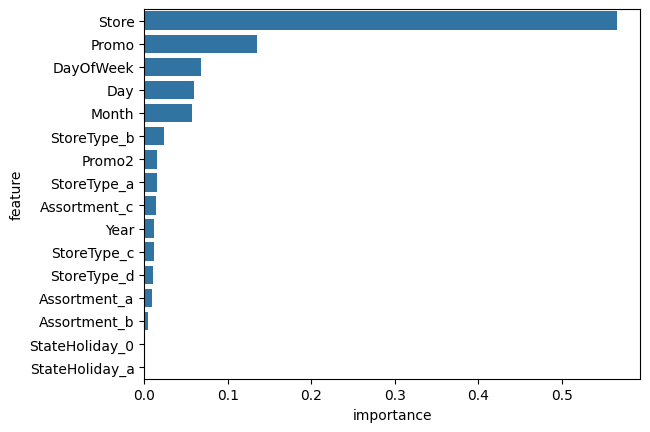

In [34]:
# Plot to visualize most important feature
sns.barplot(data=feature_importance_df, x='importance', y='feature')

In [ ]:
'''
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the model
rf = RandomForestRegressor(random_state=42)

# Initialize Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(train_input, train_target)

# Best parameters
print("Best parameters found: ", grid_search.best_params_) '''

In [35]:
# Serialize model
joblib.dump(pipe, 'trained_pipeline-0.1.0.pkl')

['trained_pipeline-0.1.0.pkl']

In [36]:
# LSTM model
X_train, X_val, y_train, y_val = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

In [37]:
X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.values.reshape((X_val.shape[0], X_val.shape[1], 1))

In [39]:
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_val = X_val.astype(np.float32)
y_val = y_val.astype(np.float32)

model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

c:\Users\Hp\Desktop\Kifiya\Week4\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
16208/16208 ━━━━━━━━━━━━━━━━━━━━ 169s 10ms/step - loss: 54884420.0000 - val_loss: 46953392.0000
Epoch 2/100
16208/16208 ━━━━━━━━━━━━━━━━━━━━ 179s 9ms/step - loss: 44633796.0000 - val_loss: 37832056.0000
Epoch 3/100
16208/16208 ━━━━━━━━━━━━━━━━━━━━ 157s 10ms/step - loss: 35910568.0000 - val_loss: 29895716.0000
Epoch 4/100
16208/16208 ━━━━━━━━━━━━━━━━━━━━ 167s 10ms/step - loss: 28178192.0000 - val_loss: 23278376.0000
Epoch 5/100
16208/16208 ━━━━━━━━━━━━━━━━━━━━ 197s 12ms/step - loss: 21887306.0000 - val_loss: 18008420.0000
Epoch 6/100
16208/16208 ━━━━━━━━━━━━━━━━━━━━ 166s 10ms/step - loss: 17008468.0000 - val_loss: 14077651.0000
Epoch 7/100
16208/16208 ━━━━━━━━━━━━━━━━━━━━ 165s 10ms/step - loss: 13361185.0000 - val_loss: 11466786.0000
Epoch 8/100
16208/16208 ━━━━━━━━━━━━━━━━━━━━ 164s 10ms/step - loss: 11103144.0000 - val_loss: 10122469.0000
Epoch 9/100
16208/16208 ━━━━━━━━━━━━━━━━━━━━ 156s 10ms/step - loss: 9998938.0000 - val_loss: 9754117.0000
Epoch 10/100
16208/16208 ━━━━━━

In [42]:
test_input = test_input.astype(np.float32)

test_predict = model.predict(test_input.values.reshape((test_input.shape[0], test_input.shape[1], 1)))
submission_df = pd.read_csv('../rossmann-store-sales/sample_submission.csv')
submission_df['Sales'] = test_predict
submission_df.to_csv('../rossmann-store-sales/submission_lstm.csv', index=False)

1284/1284 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step


### 2nd Method 

In [25]:
def get_mean(input):
    return np.full(len(input), targeted_train_df.Sales.mean())

In [28]:
dum_train_predict = get_mean(df_train)
dum_val_predict = get_mean(df_validation)

dum_train_evaluate = root_mean_squared_error(dum_train_predict, train_target)
dum_val_evaluate = root_mean_squared_error(dum_val_predict, val_target)

train_rmspe = m.rmspe(dum_train_predict, train_target)
val_rmspe = m.rmspe(dum_val_predict, val_target)

print(f"train_rmse: {dum_train_evaluate}")
print(f"val_rmse: {dum_val_evaluate}")
print()
print(f"train_rmspe: {train_rmspe}")
print(f"val_rmspe: {val_rmspe}")

train_rmse: 3123.732339927999
val_rmse: 3037.0081578600643

train_rmspe: 0.4490147852272453
val_rmspe: 0.4380030191156398


In [30]:
logit_model = LinearRegression()
try_model(logit_model)

Train RMSE: 2786.68172
Val RMSE: 2694.46393

Train RMSPE: 0.59623
Val RMSPE: 0.54469


LinearRegression()

In [34]:
decision_tree_model = DecisionTreeRegressor(random_state=42)
try_model(decision_tree_model)

Train RMSE: 0.0
Val RMSE: 1375.29298

Train RMSPE: 0.0
Val RMSPE: 0.21251


DecisionTreeRegressor(random_state=42)

In [35]:
random_forest_model = RandomForestRegressor(random_state=42, 
                                            n_jobs=-1)
try_model(random_forest_model)

c:\Users\Hp\PycharmProjects\HelloWorld\venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Train RMSE: 401.646
Val RMSE: 1137.17199

Train RMSPE: 0.09155
Val RMSPE: 0.17796


RandomForestRegressor(n_jobs=-1, random_state=42)

In [36]:
test_predict = random_forest_model.predict(test_input)
submission_df = pd.read_csv('../rossmann-store-sales/sample_submission.csv')
submission_df['Sales'] = test_predict
submission_df.to_csv('../rossmann-store-sales/submission.csv', index=False)

In [37]:
feature_importance_df = pd.DataFrame({ 
    'feature': train_input.columns, 
    'importance': random_forest_model.feature_importances_
}).sort_values('importance', ascending=False)
feature_importance_df

,feature,importance
0,Store,0.565652
2,Promo,0.134445
1,DayOfWeek,0.067574
4,Day,0.059370
5,Month,0.056645
10,StoreType_b,0.023202
3,Promo2,0.015697
9,StoreType_a,0.014666
15,Assortment_c,0.013890
6,Year,0.011256


<Axes: xlabel='importance', ylabel='feature'>

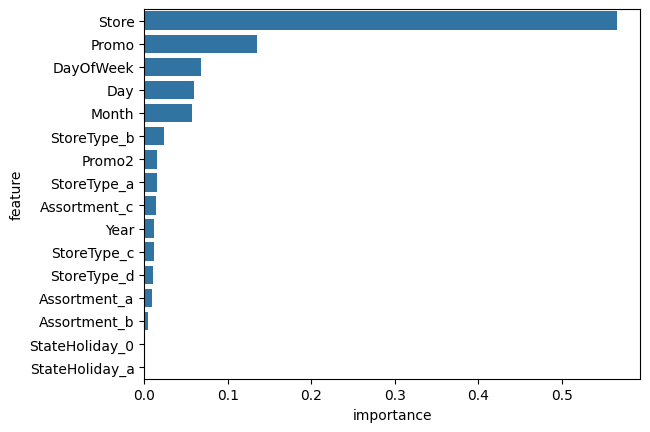

In [38]:
# Plot to visualize most important feature
sns.barplot(data=feature_importance_df, x='importance', y='feature')

In [39]:
import logging 
# Create a logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Create a file handler
handler = logging.FileHandler('logfile.log')
handler.setLevel(logging.INFO)

# Create a logging format
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# Add the handlers to the logger
logger.addHandler(handler)